In [1]:
%matplotlib inline
import os
import glob
import datetime
import warnings
import traceback

import tqdm
import dask
import dask.bag as db
import netCDF4
import scipy
import numpy as np
import matplotlib.pyplot as pl

from pyart.graph import cm

from dask.diagnostics import ProgressBar

warnings.simplefilter('ignore')

In [2]:
def griddata(r, azi, refl):
    rv = np.arange(500, 20e3, 250)
    aziv = np.arange(0, 360, 1)
    RV, AV = np.meshgrid(rv, aziv)
    R, A = np.meshgrid(r[r<20e3], azi)
    
    reflv = scipy.interpolate.griddata((R.flatten(), A.flatten()), refl.flatten(), (RV.flatten(), AV.flatten()) )
    return reflv.reshape(RV.shape)

In [3]:
def read_netcdf(infile):
    with netCDF4.Dataset(infile) as ncid:
        r = ncid['range'][:].filled(np.NaN)
        st = ncid['sweep_start_ray_index'][0]
        ed = ncid['sweep_end_ray_index'][0]
        sl = slice(st, ed)
        azi = ncid['azimuth'][sl].filled(np.NaN)
        
        refl = np.squeeze(ncid['DBZ'][sl, r < 20e3]).filled(np.NaN)
        
    try:
        return griddata(r, azi, refl)
    except Exception:
        return None

In [4]:
def process_flist(flist):
    dblist = db.from_sequence(flist)
    dbobj = dblist.map(read_netcdf)
    with ProgressBar():
        rslt = dbobj.compute()

    rslt = [r for r in rslt if r is not None]

    dbz2 = np.zeros((len(rslt), 360, 78))
    for i in range(len(rslt)):
        dbz2[i, :, :] = rslt[i]


    refl = dbz2.copy()
    refl[refl < 10] = np.NaN

    freq = np.sum(~np.isnan(refl), axis=0) / refl.shape[0]
    meanrefl2 = np.nanmean(refl, axis=0)
    
    return freq, meanrefl2

In [5]:
rv = np.arange(500, 20e3, 250)
aziv = np.arange(0, 360, 1) 
aziv -= 450
aziv[aziv < 0] += 360

RV, AV = np.meshgrid(rv, np.pi / 180 * aziv)
X = RV * np.cos(AV)
Y = RV * np.sin(AV)

In [23]:
flist = sorted(glob.glob('/g/data2/rr5/CPOL_radar/CPOL_level_1a/1998/1998121*/*.nc'))
freq_1998, meanrefl_1998 = process_flist(flist)

[########################################] | 100% Completed | 30.4s


In [24]:
# f = freq.copy()
# f[meanrefl_1998 < 30]  = np.NaN


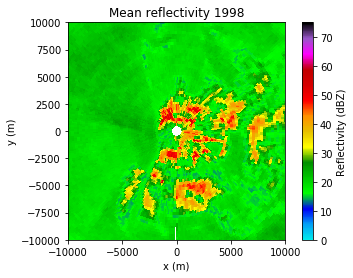

In [25]:
pl.pcolormesh(X, Y, meanrefl_1998, cmap=cm.NWSRef, vmin=-0, vmax=75)
pl.xlim(-10e3, 10e3)
pl.ylim(-10e3, 10e3)
pl.xlabel('x (m)')
pl.ylabel('y (m)')
cbar = pl.colorbar()
cbar.set_label('Reflectivity (dBZ)')
pl.title('Mean reflectivity 1998')
pl.axes().set_aspect(1)
# pl.savefig('clutter_map_1998.png', dpi=150)

In [26]:
flist = sorted(glob.glob('/g/data2/rr5/CPOL_radar/CPOL_level_1a/2006/2006010*/*.nc'))
freq_2006, meanrefl_2006 = process_flist(flist)

[########################################] | 100% Completed | 35.1s


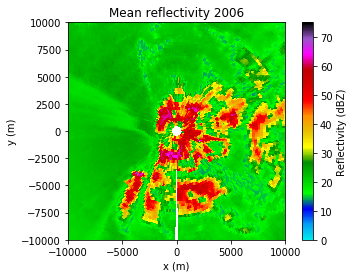

In [27]:
pl.pcolormesh(X, Y, meanrefl_2006, cmap=cm.NWSRef, vmin=-0, vmax=75)
pl.xlim(-10e3, 10e3)
pl.ylim(-10e3, 10e3)
pl.xlabel('x (m)')
pl.ylabel('y (m)')
cbar = pl.colorbar()
cbar.set_label('Reflectivity (dBZ)')
pl.title('Mean reflectivity 2006')
pl.axes().set_aspect(1)
# pl.show()
# pl.savefig('clutter_map_2006.png', dpi=150)

In [28]:
flist = sorted(glob.glob('/g/data2/rr5/CPOL_radar/CPOL_level_1a/2013/2013010*/*.nc'))
freq_2015, meanrefl_2015 = process_flist(flist)

[########################################] | 100% Completed | 20.3s


# Echo average 2013

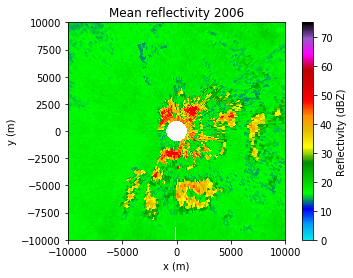

In [29]:
pl.pcolormesh(X, Y, meanrefl_2015, cmap=cm.NWSRef, vmin=-0, vmax=75)
pl.xlim(-10e3, 10e3)
pl.ylim(-10e3, 10e3)
pl.xlabel('x (m)')
pl.ylabel('y (m)')
cbar = pl.colorbar()
cbar.set_label('Reflectivity (dBZ)')
pl.title('Mean reflectivity 2006')
pl.axes().set_aspect(1)
# pl.savefig('clutter_map_2013.png', dpi=150)

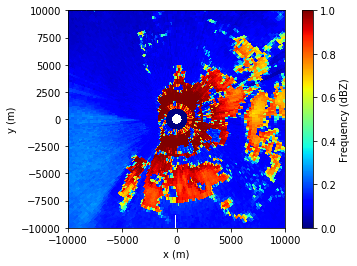

In [30]:
pl.pcolormesh(X, Y, freq_2015, cmap='jet', vmin=0, vmax=1)
pl.xlim(-10e3, 10e3)
pl.ylim(-10e3, 10e3)
pl.xlabel('x (m)')
pl.ylabel('y (m)')
cbar = pl.colorbar()
cbar.set_label('Frequency (dBZ)')
pl.axes().set_aspect(1)
pl.show()

In [31]:
from mpl_toolkits.basemap import Basemap
from numpy import pi, cos, sin

In [32]:
longitude = 131.042
latitude = -12.25
r_earth = 6378e3

In [33]:
new_latitude  = latitude  + (Y / r_earth) * (180 / pi)
new_longitude = longitude + (X / r_earth) * (180 / pi) / cos(latitude * pi/180)

In [34]:
m = Basemap(131.045 - 10 / 111, -12.25 - 10 / 111, 131.045 + 10 / 111, -12.25 + 10 / 111, projection="merc", resolution="h")
x, y = m(new_longitude, new_latitude)
parallels = np.arange(-90.,90, .1)
meridians = np.arange(0., 360.,.1)

In [35]:
def get_clutmap(clut, freq):
    pcm = clut.copy()
    pcm[(clut < 40) | (freq < 0.8)] = np.NaN
    return pcm

In [36]:
# rmdf = freq_2015.copy()

In [37]:
freq_2015[freq_2015>0.65] = 0.975

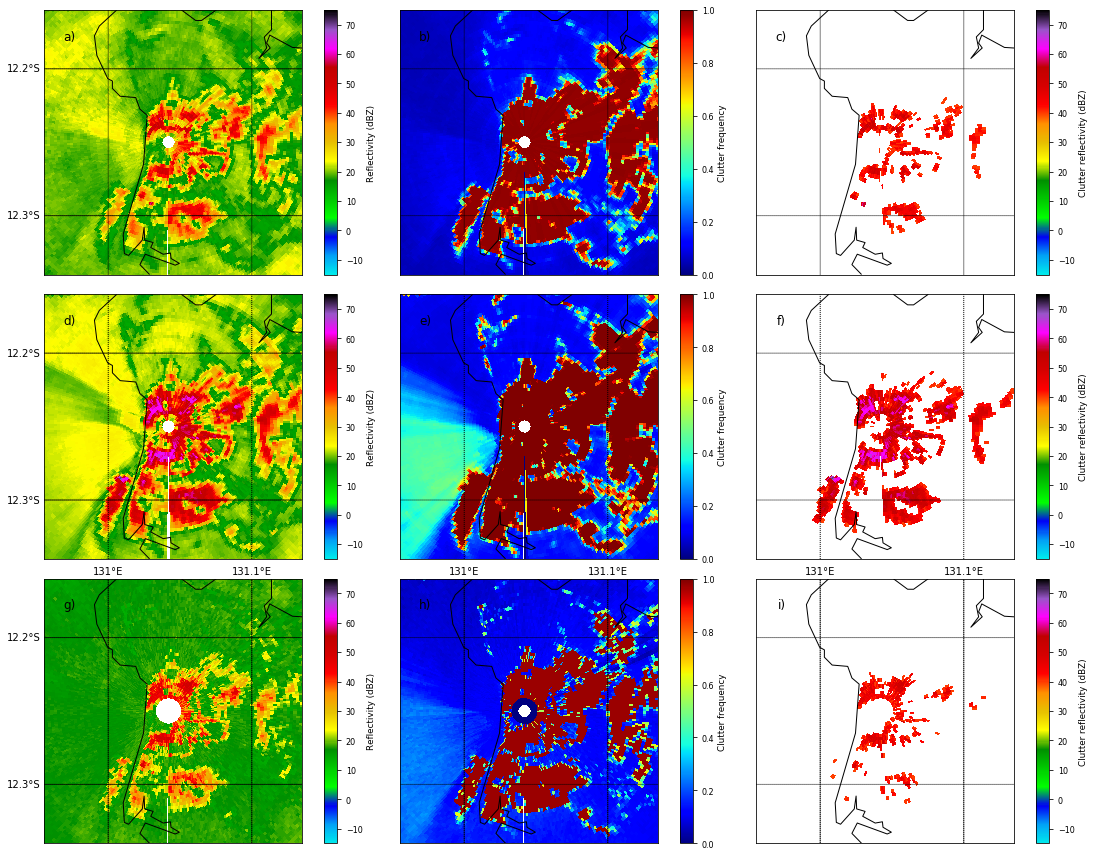

In [38]:
with pl.style.context('seaborn-paper'):
    fig, ax = pl.subplots(3, 3, sharex=True, figsize=(15, 12), sharey=True) #, 
    ax = ax.flatten()
    cax = [None] * len(ax)

    cax[0] = ax[0].pcolormesh(x, y, meanrefl_1998, cmap=cm.NWSRef, vmin=-15, vmax=75)
#     ax[0].set_title('1998')
    cax[1] = ax[1].pcolormesh(x, y, freq_1998, cmap='jet', vmin=0, vmax=1)
#     ax[1].set_title('1998')
    cax[2] = ax[2].pcolormesh(x, y, get_clutmap(meanrefl_1998, freq_1998), cmap=cm.NWSRef, vmin=-15, vmax=75)
#     ax[2].set_title('1998')

    cax[3] = ax[3].pcolormesh(x, y, meanrefl_2006, cmap=cm.NWSRef, vmin=-15, vmax=75)
#     ax[3].set_title('2006')
    cax[4] = ax[4].pcolormesh(x, y, freq_2006, cmap='jet', vmin=0, vmax=1)
#     ax[4].set_title('2006')
    cax[5] = ax[5].pcolormesh(x, y, get_clutmap(meanrefl_2006, freq_2006), cmap=cm.NWSRef, vmin=-15, vmax=75)
#     ax[5].set_title('2006')

    cax[6] = ax[6].pcolormesh(x, y, meanrefl_2015, cmap=cm.NWSRef, vmin=-15, vmax=75)
#     ax[6].set_title('2013')
    cax[7] = ax[7].pcolormesh(x, y, freq_2015, cmap='jet', vmin=0, vmax=1)
#     ax[7].set_title('2013')
    cax[8] = ax[8].pcolormesh(x, y, get_clutmap(meanrefl_2015, freq_2015), cmap=cm.NWSRef, vmin=-15, vmax=75)
#     ax[8].set_title('2013')

    for i in range(9):
        cbar = pl.colorbar(cax[i], ax=ax[i])
        if i % 3 == 0:
            cbar.set_label('Reflectivity (dBZ)')
        elif (i - 1) % 3 == 0:
            cbar.set_label('Clutter frequency')
        else:
            cbar.set_label('Clutter reflectivity (dBZ)')

    for myax in ax:    
        myax.set_aspect(1)
        m.drawcoastlines(ax=myax)
        m.drawparallels(parallels, labels=[0, 0, 0, 0], ax=myax) 
        m.drawmeridians(meridians, labels=[0, 0, 0, 0], ax=myax) 

    for i in [0, 3, 6]:
        m.drawparallels(parallels, labels=[1, 0, 0, 0], ax=ax[i])     

    for i in [6, 7, 8]:
        m.drawmeridians(meridians, labels=[0, 0, 1, 0], ax=ax[i]) 

    for i, t in enumerate('abcdefghi'):
        ax[i].text(0.1, 0.9, f'{t})', ha='center', va='center', transform=ax[i].transAxes, fontsize='large')

    fig.tight_layout()
#     fig.set_size_inches(6.4, 6.4)
    
#     pl.savefig('cpol_cmap.pdf')
#     pl.savefig('cpol_cmap.png', dpi=600)
    pl.show()

In [84]:
import matplotlib.gridspec as gridspec

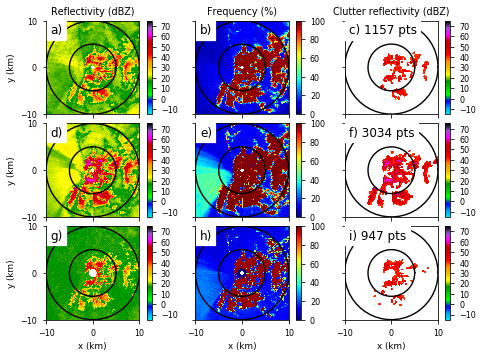

In [105]:
with pl.style.context('seaborn-paper'):
#     fig, ax = pl.subplots(3, 3, sharex=True, sharey=True, figsize=(1.61 * 5.5, 5.5)) #, 
    fig = pl.figure(figsize=(8, 5.5))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(wspace=0.01, hspace=0.1)    
    ax = [pl.subplot(gs1[i]) for i in range(9)]
    cax = [None] * len(ax)

    cax[0] = ax[0].pcolormesh(X, Y, meanrefl_1998, cmap=cm.NWSRef, vmin=-15, vmax=75)
    cax[1] = ax[1].pcolormesh(X, Y, 100 * freq_1998, cmap='jet', vmin=0, vmax=100)
    cax[2] = ax[2].pcolormesh(X, Y, get_clutmap(meanrefl_1998, freq_1998), cmap=cm.NWSRef, vmin=-15, vmax=75)

    cax[3] = ax[3].pcolormesh(X, Y, meanrefl_2006, cmap=cm.NWSRef, vmin=-15, vmax=75)
    cax[4] = ax[4].pcolormesh(X, Y, 100 * freq_2006, cmap='jet', vmin=0, vmax=100)
    cax[5] = ax[5].pcolormesh(X, Y, get_clutmap(meanrefl_2006, freq_2006), cmap=cm.NWSRef, vmin=-15, vmax=75)

    cax[6] = ax[6].pcolormesh(X, Y, meanrefl_2015, cmap=cm.NWSRef, vmin=-15, vmax=75)
    cax[7] = ax[7].pcolormesh(X, Y, 100 * freq_2015, cmap='jet', vmin=0, vmax=100)
    cax[8] = ax[8].pcolormesh(X, Y, get_clutmap(meanrefl_2015, freq_2015), cmap=cm.NWSRef, vmin=-15, vmax=75)
    ax[0].set_title('Reflectivity (dBZ)')
    ax[1].set_title('Frequency (%)')
    ax[2].set_title('Clutter reflectivity (dBZ)')
    ax[0].set_ylabel('y (km)')
    ax[3].set_ylabel('y (km)')
    ax[6].set_ylabel('y (km)')
    
    for i in range(9):
        if i < 6:
            ax[i].set_xticklabels([])
        if i not in [0, 3, 6]:
            ax[i].set_yticklabels([])    
        ax[i].set_yticks([-10, 0, 10])

    for i in range(9):
        cbar = pl.colorbar(cax[i], ax=ax[i])
        if i >= 6:
            ax[i].set_xlabel('x (km)')
    
    th = np.linspace(0, 6.3)
    for myax in ax:    
        myax.axis((-10, 10, -10, 10))        
        [myax.plot(r * np.cos(th), r * np.sin(th), 'k') for r in [5, 10]]
        myax.set_aspect(1)
    
    lbl = ['a)', 'b)', 'c) 1157 pts', 'd)', 'e)', 'f) 3034 pts', 'g)', 'h)', 'i) 947 pts']
    for i, t in enumerate(lbl):        
        ax[i].text(0.05, 0.9, t, ha='left', va='center', transform=ax[i].transAxes, fontsize='large', backgroundcolor='w')    

    
    fig.set_size_inches(8, 5.5)
#     fig.tight_layout()
    
#     pl.savefig('cpol_cmap.pdf')
    pl.savefig('cpol_cmap.png', dpi=600)
    pl.show()

$$\begin{eqnarray}
     &   & 1998 & 2006 & 2013 \\ 
\hline
1998 &  & 52.3 & 49.5 & 52.7 \\
2006 &  & 62.5 & 61.5 & 62.9 \\
2013 &  & 49.8 & 48.0 & 50.1 \\
\end{eqnarray}$$